In [2]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import optax
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from sklearn import preprocessing

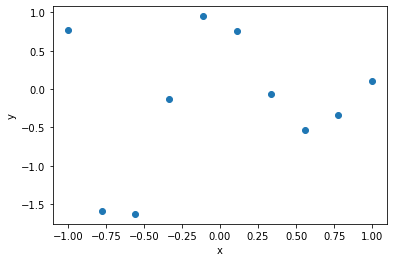

In [61]:
# function to approximate 
def f(x):
    return jnp.cos(5*jnp.prod(x, axis=1))*jnp.exp(-x[:,0])

# example in one dimension
x = jnp.linspace(-1,1,10).reshape(-1,1)
y = f(x)
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [62]:
class Regression(nn.Module):
    num_features: int
    
    def setup(self):
        self.w = self.param('weights', jax.nn.initializers.glorot_uniform(),
                                (self.num_features,1))
        self.shift = self.param('bias', jax.nn.initializers.glorot_uniform(),
                                (1,1))
    @nn.compact
    def __call__(self, x):
        out = jnp.sum(x*self.w[:,0], axis=1)
        return out + self.shift
# initializing the optimizer
learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)
# A function to generate polynomial features - equivalent to fitting using a polynomial 
def generate_poly(deg_poly, x):
    poly = PolynomialFeatures(deg_poly)
    return poly.fit_transform(x)


## Fitting using a affine mappings

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape)
# initialize the neural network 
model = Regression(1)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 2000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

(6, 1) (6,)
epoch: 0, loss function: 1.539198875427246
epoch: 100, loss function: 1.425779104232788
epoch: 200, loss function: 1.328757643699646
epoch: 300, loss function: 1.2408711910247803
epoch: 400, loss function: 1.160628318786621
epoch: 500, loss function: 1.0874536037445068
epoch: 600, loss function: 1.0208797454833984
epoch: 700, loss function: 0.9604816436767578
epoch: 800, loss function: 0.9058610796928406
epoch: 900, loss function: 0.8566404581069946
epoch: 1000, loss function: 0.8124579191207886
epoch: 1100, loss function: 0.7729659080505371
epoch: 1200, loss function: 0.7378293871879578
epoch: 1300, loss function: 0.7067245841026306
epoch: 1400, loss function: 0.6793385744094849
epoch: 1500, loss function: 0.6553689241409302
epoch: 1600, loss function: 0.6345236301422119
epoch: 1700, loss function: 0.6165207624435425
epoch: 1800, loss function: 0.6010894775390625
epoch: 1900, loss function: 0.5879690647125244


Plot the learned function.

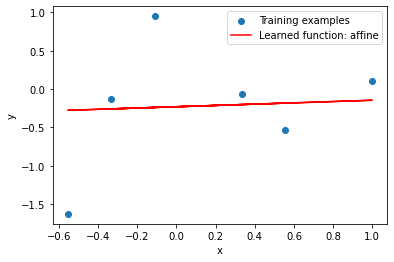

In [64]:
plt.scatter(x_train[:,0], y_train, label="Training examples")
plt.xlabel("x")
plt.ylabel("y")
params_linear = params
ypred_train = model.apply(params_linear, x_train)
plt.plot(x_train, ypred_train.T, color='r', label="Learned function: affine")
plt.legend()
plt.show()

Evaluate the training error. What do you deduce?

In [65]:

deg_poly = 100 #degree of the polynomial
x_poly = generate_poly(deg_poly, x)
scaler = preprocessing.StandardScaler().fit(x_poly)
x_poly = scaler.transform(x_poly)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)

# initialize the neural network 
model = Regression(deg_poly + 1)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 5000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 1.2124347686767578
epoch: 100, loss function: 0.4950806498527527
epoch: 200, loss function: 0.43223485350608826
epoch: 300, loss function: 0.3791384696960449
epoch: 400, loss function: 0.33435624837875366
epoch: 500, loss function: 0.2959642708301544
epoch: 600, loss function: 0.2623980641365051
epoch: 700, loss function: 0.23262916505336761
epoch: 800, loss function: 0.20605841279029846
epoch: 900, loss function: 0.1823381781578064
epoch: 1000, loss function: 0.16123484075069427
epoch: 1100, loss function: 0.14255569875240326
epoch: 1200, loss function: 0.12611906230449677
epoch: 1300, loss function: 0.11174598336219788
epoch: 1400, loss function: 0.09925857186317444
epoch: 1500, loss function: 0.08848165720701218
epoch: 1600, loss function: 0.07924361526966095
epoch: 1700, loss function: 0.07137802243232727
epoch: 1800, loss function: 0.06472475826740265
epoch: 1900, loss function: 0.059131793677806854
epoch: 2000, loss function: 0.054455798119306564
epoch: 2

We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

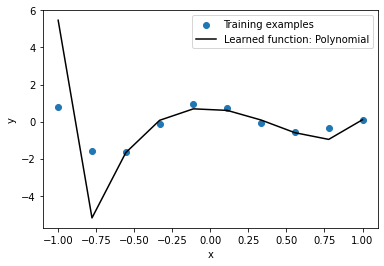

In [60]:
plt.scatter(x[:,0], y, label="Training examples")
plt.xlabel("x")
plt.ylabel("y")
params_nonlinear = params
ypred_train = model.apply(params_nonlinear, x_poly)
plt.plot(x, ypred_train.T, color='black', label="Learned function: Polynomial")
plt.legend()
plt.show()

Generate a new dataset and evaluate both hypotheses on it. What do you conclude?

One might argue that the curse of dimensionality is resulting from the fact that the basis we are using in multiple dimensions is a direct-product basis. To test the influence of this we not try to evaluate the accuracy of the model using a dimension-free prunning of the direct-product basis set. This prunnign is based on randomly sampling a subset of the full-direct product basis. 